# $\textbf{Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 15 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 16000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


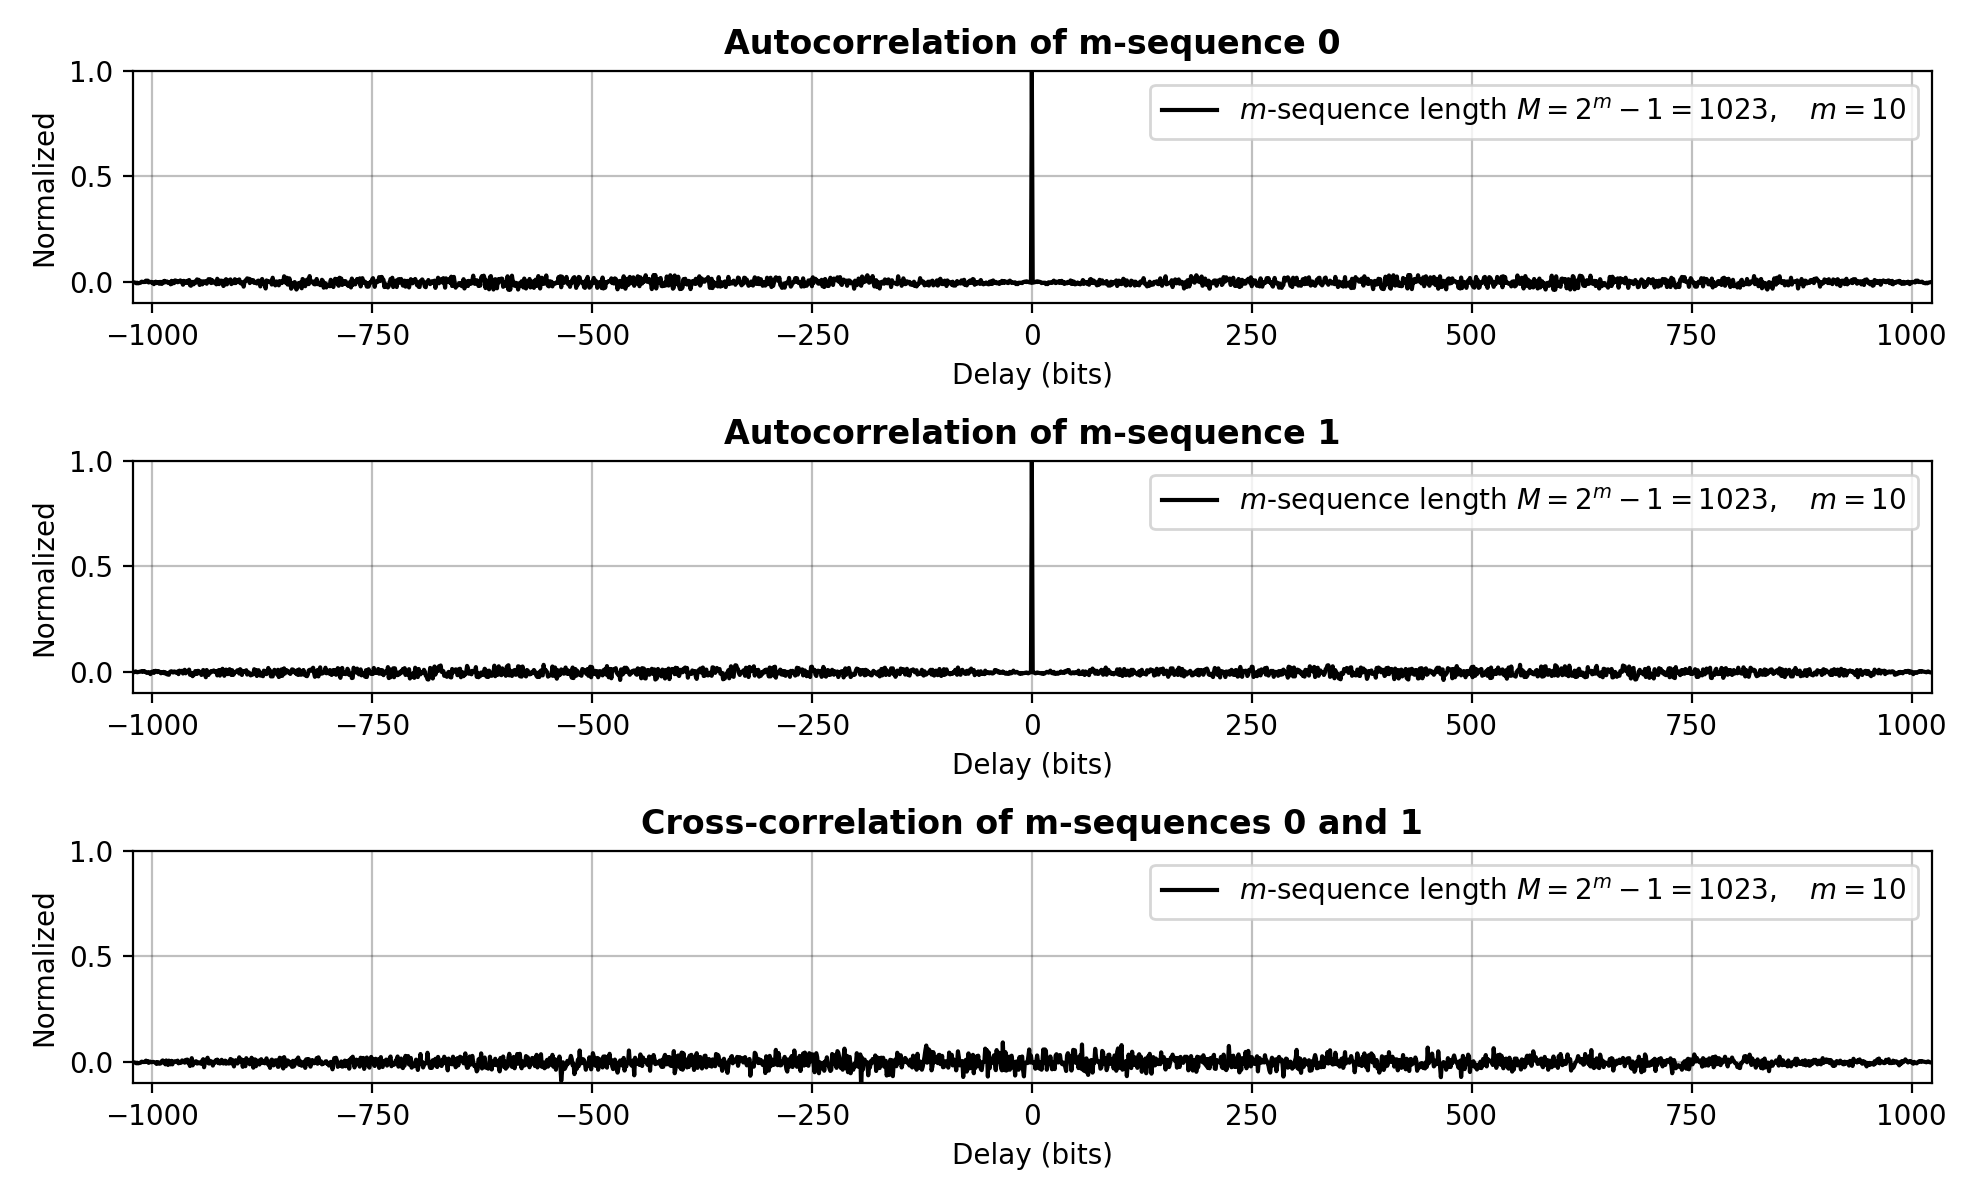

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/16000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7637 - true_positives: 1918.0000 - true_negatives: 3189.0000 - false_positives: 1921.0000 - false_negatives: 3202.0000
Epoch 2/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7582 - true_positives: 1936.0000 - true_negatives: 3181.0000 - false_positives: 1929.0000 - false_negatives: 3184.0000
Epoch 3/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7545 - true_positives: 2022.0000 - true_negatives: 3108.0000 - false_positives: 2002.0000 - false_negatives: 3098.0000
Epoch 4/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7515 - true_positives: 2015.0000 - true_negatives: 3132.0000 - false_positives: 1978.0000 - false_negatives: 3105.0000
Epoch 5/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7489 - true_positives: 2048.0000 - true_negatives: 3106.0000 - false_positives: 2004.00

Epoch 42/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7032 - true_positives: 2363.0000 - true_negatives: 3378.0000 - false_positives: 1732.0000 - false_negatives: 2757.0000
Epoch 43/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7023 - true_positives: 2381.0000 - true_negatives: 3371.0000 - false_positives: 1739.0000 - false_negatives: 2739.0000
Epoch 44/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7015 - true_positives: 2380.0000 - true_negatives: 3395.0000 - false_positives: 1715.0000 - false_negatives: 2740.0000
Epoch 45/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7006 - true_positives: 2387.0000 - true_negatives: 3383.0000 - false_positives: 1727.0000 - false_negatives: 2733.0000
Epoch 46/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6998 - true_positives: 2378.0000 - true_negatives: 3409.0000 - false_positives: 1701.0000 - false_negati

Epoch 83/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6746 - true_positives: 2707.0000 - true_negatives: 3769.0000 - false_positives: 1341.0000 - false_negatives: 2413.0000
Epoch 84/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6740 - true_positives: 2682.0000 - true_negatives: 3803.0000 - false_positives: 1307.0000 - false_negatives: 2438.0000
Epoch 85/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6735 - true_positives: 2732.0000 - true_negatives: 3786.0000 - false_positives: 1324.0000 - false_negatives: 2388.0000
Epoch 86/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6729 - true_positives: 2716.0000 - true_negatives: 3813.0000 - false_positives: 1297.0000 - false_negatives: 2404.0000
Epoch 87/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6724 - true_positives: 2762.0000 - true_negatives: 3792.0000 - false_positives: 1318.0000 - false_negati

Epoch 124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6540 - true_positives: 3332.0000 - true_negatives: 3962.0000 - false_positives: 1148.0000 - false_negatives: 1788.0000
Epoch 125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6535 - true_positives: 3381.0000 - true_negatives: 3920.0000 - false_positives: 1190.0000 - false_negatives: 1739.0000
Epoch 126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6530 - true_positives: 3355.0000 - true_negatives: 3964.0000 - false_positives: 1146.0000 - false_negatives: 1765.0000
Epoch 127/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6526 - true_positives: 3413.0000 - true_negatives: 3925.0000 - false_positives: 1185.0000 - false_negatives: 1707.0000
Epoch 128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6521 - true_positives: 3384.0000 - true_negatives: 3975.0000 - false_positives: 1135.0000 - false_n

Epoch 165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6356 - true_positives: 3923.0000 - true_negatives: 4072.0000 - false_positives: 1038.0000 - false_negatives: 1197.0000
Epoch 166/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6351 - true_positives: 3886.0000 - true_negatives: 4117.0000 - false_positives: 993.0000 - false_negatives: 1234.0000
Epoch 167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6347 - true_positives: 3957.0000 - true_negatives: 4073.0000 - false_positives: 1037.0000 - false_negatives: 1163.0000
Epoch 168/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6343 - true_positives: 3925.0000 - true_negatives: 4121.0000 - false_positives: 989.0000 - false_negatives: 1195.0000
Epoch 169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6338 - true_positives: 3989.0000 - true_negatives: 4077.0000 - false_positives: 1033.0000 - false_neg

Epoch 206/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6172 - true_positives: 4238.0000 - true_negatives: 4252.0000 - false_positives: 858.0000 - false_negatives: 882.0000
Epoch 207/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6168 - true_positives: 4287.0000 - true_negatives: 4200.0000 - false_positives: 910.0000 - false_negatives: 833.0000
Epoch 208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6163 - true_positives: 4242.0000 - true_negatives: 4257.0000 - false_positives: 853.0000 - false_negatives: 878.0000
Epoch 209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6158 - true_positives: 4297.0000 - true_negatives: 4208.0000 - false_positives: 902.0000 - false_negatives: 823.0000
Epoch 210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6154 - true_positives: 4254.0000 - true_negatives: 4264.0000 - false_positives: 846.0000 - false_negatives:

Epoch 247/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5982 - true_positives: 4414.0000 - true_negatives: 4292.0000 - false_positives: 818.0000 - false_negatives: 706.0000
Epoch 248/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5977 - true_positives: 4353.0000 - true_negatives: 4335.0000 - false_positives: 775.0000 - false_negatives: 767.0000
Epoch 249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5972 - true_positives: 4417.0000 - true_negatives: 4295.0000 - false_positives: 815.0000 - false_negatives: 703.0000
Epoch 250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5967 - true_positives: 4358.0000 - true_negatives: 4339.0000 - false_positives: 771.0000 - false_negatives: 762.0000
Epoch 251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5963 - true_positives: 4420.0000 - true_negatives: 4295.0000 - false_positives: 815.0000 - false_negatives:

Epoch 288/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5783 - true_positives: 4433.0000 - true_negatives: 4431.0000 - false_positives: 679.0000 - false_negatives: 687.0000
Epoch 289/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5778 - true_positives: 4473.0000 - true_negatives: 4395.0000 - false_positives: 715.0000 - false_negatives: 647.0000
Epoch 290/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5773 - true_positives: 4439.0000 - true_negatives: 4435.0000 - false_positives: 675.0000 - false_negatives: 681.0000
Epoch 291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5768 - true_positives: 4476.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 644.0000
Epoch 292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5763 - true_positives: 4445.0000 - true_negatives: 4436.0000 - false_positives: 674.0000 - false_negatives:

Epoch 329/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5576 - true_positives: 4531.0000 - true_negatives: 4432.0000 - false_positives: 678.0000 - false_negatives: 589.0000
Epoch 330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5571 - true_positives: 4494.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 626.0000
Epoch 331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5566 - true_positives: 4532.0000 - true_negatives: 4434.0000 - false_positives: 676.0000 - false_negatives: 588.0000
Epoch 332/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5561 - true_positives: 4497.0000 - true_negatives: 4479.0000 - false_positives: 631.0000 - false_negatives: 623.0000
Epoch 333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5556 - true_positives: 4536.0000 - true_negatives: 4436.0000 - false_positives: 674.0000 - false_negatives:

Epoch 370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5364 - true_positives: 4546.0000 - true_negatives: 4510.0000 - false_positives: 600.0000 - false_negatives: 574.0000
Epoch 371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5359 - true_positives: 4583.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 537.0000
Epoch 372/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5354 - true_positives: 4548.0000 - true_negatives: 4512.0000 - false_positives: 598.0000 - false_negatives: 572.0000
Epoch 373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5349 - true_positives: 4585.0000 - true_negatives: 4477.0000 - false_positives: 633.0000 - false_negatives: 535.0000
Epoch 374/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5344 - true_positives: 4550.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives:

Epoch 411/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5151 - true_positives: 4610.0000 - true_negatives: 4519.0000 - false_positives: 591.0000 - false_negatives: 510.0000
Epoch 412/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5146 - true_positives: 4573.0000 - true_negatives: 4560.0000 - false_positives: 550.0000 - false_negatives: 547.0000
Epoch 413/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5140 - true_positives: 4610.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negatives: 510.0000
Epoch 414/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5135 - true_positives: 4574.0000 - true_negatives: 4560.0000 - false_positives: 550.0000 - false_negatives: 546.0000
Epoch 415/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5130 - true_positives: 4612.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives:

Epoch 452/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4938 - true_positives: 4598.0000 - true_negatives: 4586.0000 - false_positives: 524.0000 - false_negatives: 522.0000
Epoch 453/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4932 - true_positives: 4633.0000 - true_negatives: 4541.0000 - false_positives: 569.0000 - false_negatives: 487.0000
Epoch 454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4927 - true_positives: 4601.0000 - true_negatives: 4587.0000 - false_positives: 523.0000 - false_negatives: 519.0000
Epoch 455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4922 - true_positives: 4633.0000 - true_negatives: 4543.0000 - false_positives: 567.0000 - false_negatives: 487.0000
Epoch 456/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4917 - true_positives: 4601.0000 - true_negatives: 4589.0000 - false_positives: 521.0000 - false_negatives:

Epoch 493/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4727 - true_positives: 4657.0000 - true_negatives: 4572.0000 - false_positives: 538.0000 - false_negatives: 463.0000
Epoch 494/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4721 - true_positives: 4610.0000 - true_negatives: 4621.0000 - false_positives: 489.0000 - false_negatives: 510.0000
Epoch 495/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4716 - true_positives: 4656.0000 - true_negatives: 4574.0000 - false_positives: 536.0000 - false_negatives: 464.0000
Epoch 496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4711 - true_positives: 4612.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives: 508.0000
Epoch 497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4706 - true_positives: 4662.0000 - true_negatives: 4571.0000 - false_positives: 539.0000 - false_negatives:

Epoch 534/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4519 - true_positives: 4642.0000 - true_negatives: 4654.0000 - false_positives: 456.0000 - false_negatives: 478.0000
Epoch 535/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4514 - true_positives: 4684.0000 - true_negatives: 4602.0000 - false_positives: 508.0000 - false_negatives: 436.0000
Epoch 536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4509 - true_positives: 4644.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives: 476.0000
Epoch 537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4504 - true_positives: 4687.0000 - true_negatives: 4601.0000 - false_positives: 509.0000 - false_negatives: 433.0000
Epoch 538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4499 - true_positives: 4645.0000 - true_negatives: 4655.0000 - false_positives: 455.0000 - false_negatives:

Epoch 575/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4315 - true_positives: 4704.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 416.0000
Epoch 576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4310 - true_positives: 4658.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negatives: 462.0000
Epoch 577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4305 - true_positives: 4704.0000 - true_negatives: 4619.0000 - false_positives: 491.0000 - false_negatives: 416.0000
Epoch 578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4300 - true_positives: 4657.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negatives: 463.0000
Epoch 579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4295 - true_positives: 4704.0000 - true_negatives: 4623.0000 - false_positives: 487.0000 - false_negatives:

Epoch 616/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4116 - true_positives: 4676.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 444.0000
Epoch 617/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4111 - true_positives: 4734.0000 - true_negatives: 4650.0000 - false_positives: 460.0000 - false_negatives: 386.0000
Epoch 618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4106 - true_positives: 4677.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 443.0000
Epoch 619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4102 - true_positives: 4735.0000 - true_negatives: 4649.0000 - false_positives: 461.0000 - false_negatives: 385.0000
Epoch 620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4097 - true_positives: 4678.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives:

Epoch 657/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3922 - true_positives: 4755.0000 - true_negatives: 4676.0000 - false_positives: 434.0000 - false_negatives: 365.0000
Epoch 658/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3918 - true_positives: 4699.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 421.0000
Epoch 659/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3913 - true_positives: 4757.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 363.0000
Epoch 660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3908 - true_positives: 4702.0000 - true_negatives: 4738.0000 - false_positives: 372.0000 - false_negatives: 418.0000
Epoch 661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3904 - true_positives: 4761.0000 - true_negatives: 4674.0000 - false_positives: 436.0000 - false_negatives:

Epoch 698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3734 - true_positives: 4713.0000 - true_negatives: 4773.0000 - false_positives: 337.0000 - false_negatives: 407.0000
Epoch 699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3730 - true_positives: 4790.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 330.0000
Epoch 700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3725 - true_positives: 4712.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 408.0000
Epoch 701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3721 - true_positives: 4790.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 330.0000
Epoch 702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3716 - true_positives: 4714.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives:

Epoch 739/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3552 - true_positives: 4805.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 315.0000
Epoch 740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3548 - true_positives: 4733.0000 - true_negatives: 4794.0000 - false_positives: 316.0000 - false_negatives: 387.0000
Epoch 741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3544 - true_positives: 4808.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 312.0000
Epoch 742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3539 - true_positives: 4732.0000 - true_negatives: 4796.0000 - false_positives: 314.0000 - false_negatives: 388.0000
Epoch 743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3535 - true_positives: 4806.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives:

Epoch 780/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3377 - true_positives: 4751.0000 - true_negatives: 4802.0000 - false_positives: 308.0000 - false_negatives: 369.0000
Epoch 781/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3373 - true_positives: 4819.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 301.0000
Epoch 782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3368 - true_positives: 4753.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives: 367.0000
Epoch 783/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3364 - true_positives: 4820.0000 - true_negatives: 4738.0000 - false_positives: 372.0000 - false_negatives: 300.0000
Epoch 784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3360 - true_positives: 4754.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives:

Epoch 821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3208 - true_positives: 4830.0000 - true_negatives: 4754.0000 - false_positives: 356.0000 - false_negatives: 290.0000
Epoch 822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3204 - true_positives: 4774.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 346.0000
Epoch 823/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3200 - true_positives: 4829.0000 - true_negatives: 4754.0000 - false_positives: 356.0000 - false_negatives: 291.0000
Epoch 824/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3196 - true_positives: 4777.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 343.0000
Epoch 825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3192 - true_positives: 4831.0000 - true_negatives: 4758.0000 - false_positives: 352.0000 - false_negatives:

Epoch 862/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3046 - true_positives: 4789.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 331.0000
Epoch 863/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3043 - true_positives: 4844.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 276.0000
Epoch 864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3039 - true_positives: 4790.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 330.0000
Epoch 865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3035 - true_positives: 4846.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 274.0000
Epoch 866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3031 - true_positives: 4791.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives:

Epoch 903/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2892 - true_positives: 4856.0000 - true_negatives: 4798.0000 - false_positives: 312.0000 - false_negatives: 264.0000
Epoch 904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2889 - true_positives: 4801.0000 - true_negatives: 4852.0000 - false_positives: 258.0000 - false_negatives: 319.0000
Epoch 905/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2885 - true_positives: 4857.0000 - true_negatives: 4800.0000 - false_positives: 310.0000 - false_negatives: 263.0000
Epoch 906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2881 - true_positives: 4801.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 319.0000
Epoch 907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2878 - true_positives: 4857.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negatives:

Epoch 944/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2746 - true_positives: 4807.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 313.0000
Epoch 945/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2742 - true_positives: 4860.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 260.0000
Epoch 946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2739 - true_positives: 4807.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 313.0000
Epoch 947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2735 - true_positives: 4862.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 258.0000
Epoch 948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2732 - true_positives: 4807.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives:

Epoch 985/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2607 - true_positives: 4875.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 245.0000
Epoch 986/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2604 - true_positives: 4821.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 299.0000
Epoch 987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2600 - true_positives: 4875.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 245.0000
Epoch 988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2597 - true_positives: 4820.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 300.0000
Epoch 989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2594 - true_positives: 4875.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives:

Epoch 1026/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2476 - true_positives: 4831.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 289.0000
Epoch 1027/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2473 - true_positives: 4879.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 241.0000
Epoch 1028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2469 - true_positives: 4831.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 289.0000
Epoch 1029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2466 - true_positives: 4879.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 241.0000
Epoch 1030/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2463 - true_positives: 4832.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 1067/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2352 - true_positives: 4884.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 236.0000
Epoch 1068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2349 - true_positives: 4834.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 286.0000
Epoch 1069/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2346 - true_positives: 4884.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 236.0000
Epoch 1070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2343 - true_positives: 4837.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 283.0000
Epoch 1071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2340 - true_positives: 4884.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 1108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2236 - true_positives: 4842.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 278.0000
Epoch 1109/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2233 - true_positives: 4887.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 233.0000
Epoch 1110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2230 - true_positives: 4842.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 278.0000
Epoch 1111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2228 - true_positives: 4886.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 234.0000
Epoch 1112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2225 - true_positives: 4842.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 1149/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2128 - true_positives: 4886.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 234.0000
Epoch 1150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2125 - true_positives: 4844.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 276.0000
Epoch 1151/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2122 - true_positives: 4888.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 232.0000
Epoch 1152/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2120 - true_positives: 4844.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 276.0000
Epoch 1153/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2117 - true_positives: 4889.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negat

Epoch 1190/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2026 - true_positives: 4850.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 270.0000
Epoch 1191/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2024 - true_positives: 4888.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 232.0000
Epoch 1192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2022 - true_positives: 4851.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 269.0000
Epoch 1193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2019 - true_positives: 4888.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 232.0000
Epoch 1194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2017 - true_positives: 4852.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negat

Epoch 1231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1932 - true_positives: 4888.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 232.0000
Epoch 1232/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1930 - true_positives: 4852.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 268.0000
Epoch 1233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1928 - true_positives: 4888.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 232.0000
Epoch 1234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1926 - true_positives: 4852.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 268.0000
Epoch 1235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1923 - true_positives: 4886.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 1272/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1844 - true_positives: 4857.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 263.0000
Epoch 1273/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1842 - true_positives: 4883.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 237.0000
Epoch 1274/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1840 - true_positives: 4856.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 264.0000
Epoch 1275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1838 - true_positives: 4882.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 238.0000
Epoch 1276/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1836 - true_positives: 4856.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 1313/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1763 - true_positives: 4883.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 237.0000
Epoch 1314/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1761 - true_positives: 4857.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 263.0000
Epoch 1315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1759 - true_positives: 4883.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 237.0000
Epoch 1316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1757 - true_positives: 4858.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 262.0000
Epoch 1317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1756 - true_positives: 4883.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 1354/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1688 - true_positives: 4856.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 264.0000
Epoch 1355/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1686 - true_positives: 4888.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 232.0000
Epoch 1356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1684 - true_positives: 4856.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 264.0000
Epoch 1357/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1683 - true_positives: 4887.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 233.0000
Epoch 1358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1681 - true_positives: 4856.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1395/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1618 - true_positives: 4888.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 232.0000
Epoch 1396/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1616 - true_positives: 4854.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 266.0000
Epoch 1397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1615 - true_positives: 4888.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 232.0000
Epoch 1398/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1613 - true_positives: 4855.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 265.0000
Epoch 1399/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1612 - true_positives: 4888.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 1436/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1554 - true_positives: 4848.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 272.0000
Epoch 1437/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1552 - true_positives: 4896.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 224.0000
Epoch 1438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1550 - true_positives: 4848.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 272.0000
Epoch 1439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1549 - true_positives: 4895.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 225.0000
Epoch 1440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1547 - true_positives: 4848.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1494 - true_positives: 4893.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 227.0000
Epoch 1478/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1493 - true_positives: 4847.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 273.0000
Epoch 1479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1491 - true_positives: 4893.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 227.0000
Epoch 1480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1490 - true_positives: 4846.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 274.0000
Epoch 1481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1488 - true_positives: 4893.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 1518/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1439 - true_positives: 4847.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 273.0000
Epoch 1519/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1438 - true_positives: 4890.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 230.0000
Epoch 1520/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1436 - true_positives: 4845.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 275.0000
Epoch 1521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1435 - true_positives: 4893.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 227.0000
Epoch 1522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1434 - true_positives: 4845.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 1559/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1388 - true_positives: 4885.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 235.0000
Epoch 1560/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1387 - true_positives: 4845.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 275.0000
Epoch 1561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1386 - true_positives: 4884.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 236.0000
Epoch 1562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1384 - true_positives: 4845.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 275.0000
Epoch 1563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1383 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negat

Epoch 1600/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1341 - true_positives: 4847.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 273.0000
Epoch 1601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1340 - true_positives: 4885.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 235.0000
Epoch 1602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1339 - true_positives: 4848.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 272.0000
Epoch 1603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1338 - true_positives: 4883.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 237.0000
Epoch 1604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1337 - true_positives: 4851.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negat

Epoch 1641/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1298 - true_positives: 4885.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 235.0000
Epoch 1642/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1297 - true_positives: 4851.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 269.0000
Epoch 1643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1296 - true_positives: 4885.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 235.0000
Epoch 1644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1295 - true_positives: 4851.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 269.0000
Epoch 1645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1294 - true_positives: 4885.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 1682/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1258 - true_positives: 4843.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 277.0000
Epoch 1683/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1257 - true_positives: 4886.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 234.0000
Epoch 1684/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1256 - true_positives: 4844.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 276.0000
Epoch 1685/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1255 - true_positives: 4886.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 234.0000
Epoch 1686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1254 - true_positives: 4844.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negat

Epoch 1723/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1221 - true_positives: 4885.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 235.0000
Epoch 1724/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1220 - true_positives: 4853.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 267.0000
Epoch 1725/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1220 - true_positives: 4886.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 234.0000
Epoch 1726/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1219 - true_positives: 4853.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 267.0000
Epoch 1727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1218 - true_positives: 4887.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negat

Epoch 1764/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1187 - true_positives: 4851.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 269.0000
Epoch 1765/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1187 - true_positives: 4888.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 232.0000
Epoch 1766/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1186 - true_positives: 4851.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 269.0000
Epoch 1767/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1185 - true_positives: 4887.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 233.0000
Epoch 1768/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1184 - true_positives: 4851.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negat

Epoch 1805/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1156 - true_positives: 4887.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 233.0000
Epoch 1806/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1155 - true_positives: 4856.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 264.0000
Epoch 1807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1155 - true_positives: 4886.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 234.0000
Epoch 1808/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1154 - true_positives: 4857.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 263.0000
Epoch 1809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1153 - true_positives: 4887.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 1846/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1127 - true_positives: 4858.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 262.0000
Epoch 1847/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1127 - true_positives: 4883.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 237.0000
Epoch 1848/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1126 - true_positives: 4858.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 262.0000
Epoch 1849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1125 - true_positives: 4883.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 237.0000
Epoch 1850/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1124 - true_positives: 4859.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 1887/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1100 - true_positives: 4880.0000 - true_negatives: 4852.0000 - false_positives: 258.0000 - false_negatives: 240.0000
Epoch 1888/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1100 - true_positives: 4857.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 263.0000
Epoch 1889/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1099 - true_positives: 4880.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negatives: 240.0000
Epoch 1890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1099 - true_positives: 4856.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 264.0000
Epoch 1891/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1098 - true_positives: 4880.0000 - true_negatives: 4851.0000 - false_positives: 259.0000 - false_negat

Epoch 1928/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1076 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 265.0000
Epoch 1929/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1075 - true_positives: 4881.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 239.0000
Epoch 1930/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1075 - true_positives: 4854.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 266.0000
Epoch 1931/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1074 - true_positives: 4881.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 239.0000
Epoch 1932/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1073 - true_positives: 4854.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 1969/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1053 - true_positives: 4882.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 238.0000
Epoch 1970/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1052 - true_positives: 4855.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 265.0000
Epoch 1971/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1052 - true_positives: 4882.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 238.0000
Epoch 1972/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1051 - true_positives: 4855.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 265.0000
Epoch 1973/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1051 - true_positives: 4882.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 2010/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1032 - true_positives: 4856.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 264.0000
Epoch 2011/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1031 - true_positives: 4890.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 230.0000
Epoch 2012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1031 - true_positives: 4857.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 263.0000
Epoch 2013/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1030 - true_positives: 4890.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 230.0000
Epoch 2014/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1030 - true_positives: 4858.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 2051/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1012 - true_positives: 4890.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 230.0000
Epoch 2052/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1011 - true_positives: 4858.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 262.0000
Epoch 2053/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1011 - true_positives: 4890.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 230.0000
Epoch 2054/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1010 - true_positives: 4857.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 263.0000
Epoch 2055/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1010 - true_positives: 4890.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negat

Epoch 2092/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0994 - true_positives: 4861.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 259.0000
Epoch 2093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0993 - true_positives: 4893.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 227.0000
Epoch 2094/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0993 - true_positives: 4861.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 259.0000
Epoch 2095/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0992 - true_positives: 4893.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 227.0000
Epoch 2096/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0992 - true_positives: 4861.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 2133/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0977 - true_positives: 4897.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 223.0000
Epoch 2134/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0976 - true_positives: 4862.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 258.0000
Epoch 2135/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0976 - true_positives: 4896.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negatives: 224.0000
Epoch 2136/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0975 - true_positives: 4861.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 259.0000
Epoch 2137/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0975 - true_positives: 4895.0000 - true_negatives: 4847.0000 - false_positives: 263.0000 - false_negat

Epoch 2174/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0961 - true_positives: 4861.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 259.0000
Epoch 2175/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0960 - true_positives: 4895.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 225.0000
Epoch 2176/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0960 - true_positives: 4863.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 257.0000
Epoch 2177/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0960 - true_positives: 4895.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 225.0000
Epoch 2178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0959 - true_positives: 4863.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negat

Epoch 2215/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0946 - true_positives: 4893.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 227.0000
Epoch 2216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0946 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 2217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0945 - true_positives: 4893.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negatives: 227.0000
Epoch 2218/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0945 - true_positives: 4867.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 253.0000
Epoch 2219/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0945 - true_positives: 4895.0000 - true_negatives: 4846.0000 - false_positives: 264.0000 - false_negat

Epoch 2256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0932 - true_positives: 4869.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 251.0000
Epoch 2257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0932 - true_positives: 4896.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 224.0000
Epoch 2258/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0932 - true_positives: 4869.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 251.0000
Epoch 2259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0931 - true_positives: 4896.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 224.0000
Epoch 2260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0931 - true_positives: 4869.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 2297/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0919 - true_positives: 4897.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 223.0000
Epoch 2298/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0919 - true_positives: 4871.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 249.0000
Epoch 2299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0919 - true_positives: 4897.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 223.0000
Epoch 2300/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0919 - true_positives: 4871.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 249.0000
Epoch 2301/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0918 - true_positives: 4897.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 2338/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0907 - true_positives: 4870.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 250.0000
Epoch 2339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0907 - true_positives: 4896.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 224.0000
Epoch 2340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0907 - true_positives: 4870.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 250.0000
Epoch 2341/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0907 - true_positives: 4896.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 224.0000
Epoch 2342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0906 - true_positives: 4870.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 2379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0896 - true_positives: 4895.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 225.0000
Epoch 2380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0896 - true_positives: 4868.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 252.0000
Epoch 2381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0896 - true_positives: 4895.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 225.0000
Epoch 2382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0896 - true_positives: 4868.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 252.0000
Epoch 2383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0895 - true_positives: 4895.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 2420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0886 - true_positives: 4873.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 247.0000
Epoch 2421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0886 - true_positives: 4898.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 222.0000
Epoch 2422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0885 - true_positives: 4872.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 248.0000
Epoch 2423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0885 - true_positives: 4899.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 221.0000
Epoch 2424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0885 - true_positives: 4872.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 2461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0876 - true_positives: 4897.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 223.0000
Epoch 2462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0876 - true_positives: 4870.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 250.0000
Epoch 2463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0876 - true_positives: 4897.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 223.0000
Epoch 2464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0875 - true_positives: 4870.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 250.0000
Epoch 2465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0875 - true_positives: 4897.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negat

Epoch 2502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0867 - true_positives: 4873.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 247.0000
Epoch 2503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0867 - true_positives: 4894.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 226.0000
Epoch 2504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4873.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 247.0000
Epoch 2505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4895.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 225.0000
Epoch 2506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4873.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negat

Epoch 2543/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0858 - true_positives: 4896.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 224.0000
Epoch 2544/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0858 - true_positives: 4872.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 248.0000
Epoch 2545/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0858 - true_positives: 4897.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 223.0000
Epoch 2546/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0857 - true_positives: 4872.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 248.0000
Epoch 2547/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0857 - true_positives: 4898.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negat

Epoch 2584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0850 - true_positives: 4875.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 245.0000
Epoch 2585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0850 - true_positives: 4898.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 222.0000
Epoch 2586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0849 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 246.0000
Epoch 2587/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4898.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 222.0000
Epoch 2588/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4874.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 2625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4899.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 221.0000
Epoch 2626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4879.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 241.0000
Epoch 2627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4898.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 222.0000
Epoch 2628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4879.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 241.0000
Epoch 2629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0841 - true_positives: 4898.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negat

Epoch 2666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 239.0000
Epoch 2667/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0835 - true_positives: 4900.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 220.0000
Epoch 2668/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0834 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2669/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0834 - true_positives: 4900.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 220.0000
Epoch 2670/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0834 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negat

Epoch 2707/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0828 - true_positives: 4901.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 219.0000
Epoch 2708/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0828 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2709/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0827 - true_positives: 4901.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 219.0000
Epoch 2710/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0827 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2711/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0827 - true_positives: 4901.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negat

Epoch 2748/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0821 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2749/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0821 - true_positives: 4900.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 220.0000
Epoch 2750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0821 - true_positives: 4881.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negatives: 239.0000
Epoch 2751/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0821 - true_positives: 4902.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 218.0000
Epoch 2752/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0821 - true_positives: 4881.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 2789/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0815 - true_positives: 4901.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 219.0000
Epoch 2790/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0815 - true_positives: 4879.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 241.0000
Epoch 2791/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0815 - true_positives: 4900.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 220.0000
Epoch 2792/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0815 - true_positives: 4881.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negatives: 239.0000
Epoch 2793/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0814 - true_positives: 4899.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negat

Epoch 2830/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2831/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4901.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 219.0000
Epoch 2832/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4880.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 240.0000
Epoch 2833/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4900.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 220.0000
Epoch 2834/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0809 - true_positives: 4882.0000 - true_negatives: 4858.0000 - false_positives: 252.0000 - false_negat

Epoch 2871/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4902.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 218.0000
Epoch 2872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4881.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 239.0000
Epoch 2873/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4902.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 218.0000
Epoch 2874/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4880.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 240.0000
Epoch 2875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0803 - true_positives: 4902.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 2912/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 238.0000
Epoch 2913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4902.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 218.0000
Epoch 2914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 238.0000
Epoch 2915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4902.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 218.0000
Epoch 2916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0798 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negat

Epoch 2953/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0793 - true_positives: 4901.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 219.0000
Epoch 2954/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0793 - true_positives: 4882.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 238.0000
Epoch 2955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0793 - true_positives: 4900.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 220.0000
Epoch 2956/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0793 - true_positives: 4883.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 237.0000
Epoch 2957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0792 - true_positives: 4900.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negat

Epoch 2994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0788 - true_positives: 4885.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 235.0000
Epoch 2995/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0788 - true_positives: 4898.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 222.0000
Epoch 2996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0788 - true_positives: 4885.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 235.0000
Epoch 2997/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0788 - true_positives: 4901.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 219.0000
Epoch 2998/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0787 - true_positives: 4885.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negat

Epoch 3035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0783 - true_positives: 4898.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 222.0000
Epoch 3036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0783 - true_positives: 4887.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 233.0000
Epoch 3037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0783 - true_positives: 4898.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 222.0000
Epoch 3038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0783 - true_positives: 4887.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 233.0000
Epoch 3039/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0783 - true_positives: 4898.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 3076/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0779 - true_positives: 4890.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 230.0000
Epoch 3077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0779 - true_positives: 4896.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 224.0000
Epoch 3078/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4890.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 230.0000
Epoch 3079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4896.0000 - true_negatives: 4855.0000 - false_positives: 255.0000 - false_negatives: 224.0000
Epoch 3080/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0778 - true_positives: 4890.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 3117/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4899.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 221.0000
Epoch 3118/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4891.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 229.0000
Epoch 3119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4900.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 220.0000
Epoch 3120/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4891.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 229.0000
Epoch 3121/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4900.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 3158/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4889.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 231.0000
Epoch 3159/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4901.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 219.0000
Epoch 3160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4889.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 231.0000
Epoch 3161/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4901.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 219.0000
Epoch 3162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4889.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 3199/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0766 - true_positives: 4902.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 218.0000
Epoch 3200/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0766 - true_positives: 4891.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 229.0000
Epoch 3201/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0766 - true_positives: 4902.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 218.0000
Epoch 3202/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0766 - true_positives: 4891.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 229.0000
Epoch 3203/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0766 - true_positives: 4902.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negat

Epoch 3240/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4894.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 226.0000
Epoch 3241/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4901.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 219.0000
Epoch 3242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4894.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 226.0000
Epoch 3243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4900.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 220.0000
Epoch 3244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0762 - true_positives: 4894.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 3281/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0758 - true_positives: 4903.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 217.0000
Epoch 3282/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0758 - true_positives: 4893.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 227.0000
Epoch 3283/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0758 - true_positives: 4903.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 217.0000
Epoch 3284/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0758 - true_positives: 4893.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 227.0000
Epoch 3285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0758 - true_positives: 4903.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negat

Epoch 3322/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4894.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 226.0000
Epoch 3323/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4907.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 213.0000
Epoch 3324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4894.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 226.0000
Epoch 3325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4907.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 213.0000
Epoch 3326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4893.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 3363/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0751 - true_positives: 4913.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 207.0000
Epoch 3364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4897.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 223.0000
Epoch 3365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0750 - true_positives: 4913.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 207.0000
Epoch 3366/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0750 - true_positives: 4896.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 224.0000
Epoch 3367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0750 - true_positives: 4913.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negat

Epoch 3404/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4899.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 221.0000
Epoch 3405/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4912.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 208.0000
Epoch 3406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4901.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 219.0000
Epoch 3407/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4911.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 209.0000
Epoch 3408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0747 - true_positives: 4901.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 3445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4910.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 210.0000
Epoch 3446/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0743 - true_positives: 4901.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 219.0000
Epoch 3447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4910.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negatives: 210.0000
Epoch 3448/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0743 - true_positives: 4901.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 219.0000
Epoch 3449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0743 - true_positives: 4910.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 3486/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4902.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 218.0000
Epoch 3487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4910.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 210.0000
Epoch 3488/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4902.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 218.0000
Epoch 3489/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4911.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 209.0000
Epoch 3490/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0740 - true_positives: 4902.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negat

Epoch 3527/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0736 - true_positives: 4912.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 208.0000
Epoch 3528/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4903.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 217.0000
Epoch 3529/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4912.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 208.0000
Epoch 3530/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4903.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 217.0000
Epoch 3531/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0736 - true_positives: 4912.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 3568/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4903.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 217.0000
Epoch 3569/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4912.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 208.0000
Epoch 3570/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4903.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 217.0000
Epoch 3571/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4913.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 207.0000
Epoch 3572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4903.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negat

Epoch 3609/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4916.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 204.0000
Epoch 3610/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0729 - true_positives: 4906.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 214.0000
Epoch 3611/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0729 - true_positives: 4917.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 203.0000
Epoch 3612/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4906.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 214.0000
Epoch 3613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0729 - true_positives: 4917.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 3650/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0726 - true_positives: 4910.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 210.0000
Epoch 3651/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0726 - true_positives: 4916.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 204.0000
Epoch 3652/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0726 - true_positives: 4910.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 210.0000
Epoch 3653/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0726 - true_positives: 4916.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 204.0000
Epoch 3654/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0726 - true_positives: 4910.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negat

Epoch 3691/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0723 - true_positives: 4917.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 203.0000
Epoch 3692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4911.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 209.0000
Epoch 3693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4917.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 203.0000
Epoch 3694/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4911.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 209.0000
Epoch 3695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4916.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 3732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4912.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 208.0000
Epoch 3733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4919.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 201.0000
Epoch 3734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 4912.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 208.0000
Epoch 3735/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 4919.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 201.0000
Epoch 3736/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4912.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negat

Epoch 3773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 4922.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 198.0000
Epoch 3774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4914.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 206.0000
Epoch 3775/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0715 - true_positives: 4922.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 198.0000
Epoch 3776/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4914.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 206.0000
Epoch 3777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4922.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negat

Epoch 3814/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4917.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 203.0000
Epoch 3815/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4926.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 194.0000
Epoch 3816/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4917.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 203.0000
Epoch 3817/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4926.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 194.0000
Epoch 3818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4918.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negat

Epoch 3855/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 4926.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 194.0000
Epoch 3856/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 4919.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 201.0000
Epoch 3857/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4926.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 194.0000
Epoch 3858/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4920.0000 - true_negatives: 4893.0000 - false_positives: 217.0000 - false_negatives: 200.0000
Epoch 3859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 4926.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negat

Epoch 3896/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4921.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 199.0000
Epoch 3897/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4929.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 191.0000
Epoch 3898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4921.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 199.0000
Epoch 3899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 4929.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 191.0000
Epoch 3900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 4921.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negat

Epoch 3937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4933.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 187.0000
Epoch 3938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4927.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 193.0000
Epoch 3939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4933.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 187.0000
Epoch 3940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4927.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 193.0000
Epoch 3941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4933.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negat

Epoch 3978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4929.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 191.0000
Epoch 3979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4934.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 186.0000
Epoch 3980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4929.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 191.0000
Epoch 3981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4934.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 186.0000
Epoch 3982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4929.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negat

Epoch 4019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4939.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 181.0000
Epoch 4020/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4931.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 189.0000
Epoch 4021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4939.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 181.0000
Epoch 4022/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0693 - true_positives: 4932.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 188.0000
Epoch 4023/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0693 - true_positives: 4940.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negat

Epoch 4060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4935.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 185.0000
Epoch 4061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4943.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 177.0000
Epoch 4062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4935.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 185.0000
Epoch 4063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4943.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 177.0000
Epoch 4064/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0689 - true_positives: 4935.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negat

Epoch 4101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4944.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 176.0000
Epoch 4102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4939.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 181.0000
Epoch 4103/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4944.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 176.0000
Epoch 4104/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4941.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 179.0000
Epoch 4105/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4944.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 4142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4939.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 181.0000
Epoch 4143/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4946.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 174.0000
Epoch 4144/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4940.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 180.0000
Epoch 4145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4946.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 174.0000
Epoch 4146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4940.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negat

Epoch 4183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0678 - true_positives: 4949.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 171.0000
Epoch 4184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0678 - true_positives: 4943.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 177.0000
Epoch 4185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4949.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 171.0000
Epoch 4186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4943.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 177.0000
Epoch 4187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4949.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negat

Epoch 4224/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4947.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 173.0000
Epoch 4225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4951.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 169.0000
Epoch 4226/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4947.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 173.0000
Epoch 4227/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4951.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 169.0000
Epoch 4228/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4947.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negat

Epoch 4265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4954.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 166.0000
Epoch 4266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4952.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 168.0000
Epoch 4267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4954.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 166.0000
Epoch 4268/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0670 - true_positives: 4952.0000 - true_negatives: 4919.0000 - false_positives: 191.0000 - false_negatives: 168.0000
Epoch 4269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4954.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negat

Epoch 4306/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0666 - true_positives: 4954.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 166.0000
Epoch 4307/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0666 - true_positives: 4958.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 162.0000
Epoch 4308/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0666 - true_positives: 4953.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 167.0000
Epoch 4309/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0665 - true_positives: 4958.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 162.0000
Epoch 4310/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0665 - true_positives: 4954.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negat

Epoch 4347/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4963.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 157.0000
Epoch 4348/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 4955.0000 - true_negatives: 4926.0000 - false_positives: 184.0000 - false_negatives: 165.0000
Epoch 4349/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4963.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 157.0000
Epoch 4350/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0661 - true_positives: 4955.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 165.0000
Epoch 4351/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4964.0000 - true_negatives: 4920.0000 - false_positives: 190.0000 - false_negat

Epoch 4388/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0657 - true_positives: 4960.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 160.0000
Epoch 4389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0657 - true_positives: 4971.0000 - true_negatives: 4928.0000 - false_positives: 182.0000 - false_negatives: 149.0000
Epoch 4390/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0657 - true_positives: 4961.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 159.0000
Epoch 4391/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0657 - true_positives: 4971.0000 - true_negatives: 4929.0000 - false_positives: 181.0000 - false_negatives: 149.0000
Epoch 4392/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0657 - true_positives: 4962.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negat

Epoch 4429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4973.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 147.0000
Epoch 4430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0652 - true_positives: 4970.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 150.0000
Epoch 4431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0652 - true_positives: 4973.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 147.0000
Epoch 4432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0652 - true_positives: 4970.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 150.0000
Epoch 4433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0652 - true_positives: 4973.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negat

Epoch 4470/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0648 - true_positives: 4971.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 149.0000
Epoch 4471/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0648 - true_positives: 4975.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 145.0000
Epoch 4472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0648 - true_positives: 4971.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 149.0000
Epoch 4473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0648 - true_positives: 4975.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 145.0000
Epoch 4474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0647 - true_positives: 4971.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negat

Epoch 4511/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0643 - true_positives: 4983.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 137.0000
Epoch 4512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0643 - true_positives: 4973.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 147.0000
Epoch 4513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0643 - true_positives: 4983.0000 - true_negatives: 4933.0000 - false_positives: 177.0000 - false_negatives: 137.0000
Epoch 4514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0643 - true_positives: 4974.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 146.0000
Epoch 4515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0643 - true_positives: 4983.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negat

Epoch 4552/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0638 - true_positives: 4981.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 139.0000
Epoch 4553/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4987.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 133.0000
Epoch 4554/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4981.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 139.0000
Epoch 4555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4987.0000 - true_negatives: 4937.0000 - false_positives: 173.0000 - false_negatives: 133.0000
Epoch 4556/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0638 - true_positives: 4981.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negat

Epoch 4593/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4992.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 128.0000
Epoch 4594/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4989.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negatives: 131.0000
Epoch 4595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4992.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 128.0000
Epoch 4596/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0633 - true_positives: 4989.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negatives: 131.0000
Epoch 4597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0633 - true_positives: 4992.0000 - true_negatives: 4940.0000 - false_positives: 170.0000 - false_negat

Epoch 4634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0628 - true_positives: 4991.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 129.0000
Epoch 4635/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0628 - true_positives: 4995.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 125.0000
Epoch 4636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0628 - true_positives: 4991.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 129.0000
Epoch 4637/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0628 - true_positives: 4996.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 124.0000
Epoch 4638/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 4991.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negat

Epoch 4675/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0623 - true_positives: 5001.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 119.0000
Epoch 4676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4997.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 123.0000
Epoch 4677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 5001.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 119.0000
Epoch 4678/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0622 - true_positives: 4997.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 123.0000
Epoch 4679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 5001.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negat

Epoch 4716/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0617 - true_positives: 5003.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 117.0000
Epoch 4717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0617 - true_positives: 5004.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 116.0000
Epoch 4718/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0617 - true_positives: 5003.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 117.0000
Epoch 4719/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0617 - true_positives: 5004.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 116.0000
Epoch 4720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0616 - true_positives: 5003.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negat

Epoch 4757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0611 - true_positives: 5006.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 114.0000
Epoch 4758/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0611 - true_positives: 5004.0000 - true_negatives: 4948.0000 - false_positives: 162.0000 - false_negatives: 116.0000
Epoch 4759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0611 - true_positives: 5006.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 114.0000
Epoch 4760/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0611 - true_positives: 5004.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_negatives: 116.0000
Epoch 4761/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0611 - true_positives: 5007.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negat

Epoch 4798/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0605 - true_positives: 5008.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 112.0000
Epoch 4799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0605 - true_positives: 5014.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_negatives: 106.0000
Epoch 4800/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0605 - true_positives: 5009.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 111.0000
Epoch 4801/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0605 - true_positives: 5014.0000 - true_negatives: 4949.0000 - false_positives: 161.0000 - false_negatives: 106.0000
Epoch 4802/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0605 - true_positives: 5009.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negat

Epoch 4839/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 5021.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 99.0000
Epoch 4840/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 5018.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 102.0000
Epoch 4841/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 5021.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 99.0000
Epoch 4842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 5018.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 102.0000
Epoch 4843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 5021.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negativ

Epoch 4880/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0593 - true_positives: 5018.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 102.0000
Epoch 4881/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0593 - true_positives: 5022.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 98.0000
Epoch 4882/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0593 - true_positives: 5018.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negatives: 102.0000
Epoch 4883/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0592 - true_positives: 5022.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 98.0000
Epoch 4884/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0592 - true_positives: 5018.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negativ

Epoch 4921/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0586 - true_positives: 5025.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 95.0000
Epoch 4922/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0586 - true_positives: 5021.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 99.0000
Epoch 4923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0586 - true_positives: 5025.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 95.0000
Epoch 4924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0586 - true_positives: 5021.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 99.0000
Epoch 4925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0586 - true_positives: 5025.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives

Epoch 4962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 5027.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 93.0000
Epoch 4963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 5030.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 90.0000
Epoch 4964/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0579 - true_positives: 5027.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 93.0000
Epoch 4965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 5030.0000 - true_negatives: 4961.0000 - false_positives: 149.0000 - false_negatives: 90.0000
Epoch 4966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 5027.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives

Epoch 5003/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5033.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 87.0000
Epoch 5004/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5029.0000 - true_negatives: 4968.0000 - false_positives: 142.0000 - false_negatives: 91.0000
Epoch 5005/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5033.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 87.0000
Epoch 5006/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5029.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 91.0000
Epoch 5007/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0572 - true_positives: 5033.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives

Epoch 5044/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5027.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 93.0000
Epoch 5045/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0565 - true_positives: 5034.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 86.0000
Epoch 5046/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0565 - true_positives: 5027.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 93.0000
Epoch 5047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0565 - true_positives: 5034.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 86.0000
Epoch 5048/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0565 - true_positives: 5026.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives

Epoch 5085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 5033.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 87.0000
Epoch 5086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 5031.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 89.0000
Epoch 5087/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 5033.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 87.0000
Epoch 5088/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0557 - true_positives: 5031.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 89.0000
Epoch 5089/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0557 - true_positives: 5033.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives

Epoch 5126/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0550 - true_positives: 5031.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 89.0000
Epoch 5127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0550 - true_positives: 5035.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 85.0000
Epoch 5128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 5031.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 89.0000
Epoch 5129/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 5035.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 85.0000
Epoch 5130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 5031.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives

Epoch 5167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5036.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 84.0000
Epoch 5168/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5034.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 86.0000
Epoch 5169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5036.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 84.0000
Epoch 5170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5034.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 86.0000
Epoch 5171/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0542 - true_positives: 5036.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives

Epoch 5208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0535 - true_positives: 5036.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 84.0000
Epoch 5209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0534 - true_positives: 5039.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 81.0000
Epoch 5210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0534 - true_positives: 5036.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 84.0000
Epoch 5211/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0534 - true_positives: 5039.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 81.0000
Epoch 5212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0534 - true_positives: 5036.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives

Epoch 5249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0526 - true_positives: 5040.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 80.0000
Epoch 5250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0526 - true_positives: 5039.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 81.0000
Epoch 5251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0526 - true_positives: 5040.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 80.0000
Epoch 5252/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0526 - true_positives: 5039.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 81.0000
Epoch 5253/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0526 - true_positives: 5040.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives

Epoch 5290/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5040.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 80.0000
Epoch 5291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5042.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 78.0000
Epoch 5292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5040.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 80.0000
Epoch 5293/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5042.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 78.0000
Epoch 5294/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0517 - true_positives: 5040.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives

Epoch 5331/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0510 - true_positives: 5044.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 76.0000
Epoch 5332/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0510 - true_positives: 5040.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 80.0000
Epoch 5333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5044.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 76.0000
Epoch 5334/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5041.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 79.0000
Epoch 5335/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0509 - true_positives: 5044.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives

Epoch 5372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0501 - true_positives: 5044.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 76.0000
Epoch 5373/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0501 - true_positives: 5047.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 73.0000
Epoch 5374/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0501 - true_positives: 5044.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 76.0000
Epoch 5375/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0501 - true_positives: 5047.0000 - true_negatives: 5000.0000 - false_positives: 110.0000 - false_negatives: 73.0000
Epoch 5376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0501 - true_positives: 5044.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives

Epoch 5413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0493 - true_positives: 5048.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 72.0000
Epoch 5414/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0493 - true_positives: 5047.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 73.0000
Epoch 5415/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0493 - true_positives: 5049.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 71.0000
Epoch 5416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0492 - true_positives: 5047.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 73.0000
Epoch 5417/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0492 - true_positives: 5049.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives

Epoch 5454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0485 - true_positives: 5048.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 72.0000
Epoch 5455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0484 - true_positives: 5050.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 70.0000
Epoch 5456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0484 - true_positives: 5048.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 72.0000
Epoch 5457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0484 - true_positives: 5050.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 70.0000
Epoch 5458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0484 - true_positives: 5047.0000 - true_negatives: 5014.0000 - false_positives: 96.0000 - false_negatives: 73.

Epoch 5495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5053.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 67.0000
Epoch 5496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5049.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 71.0000
Epoch 5497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5053.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 67.0000
Epoch 5498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0475 - true_positives: 5051.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 69.0000
Epoch 5499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0475 - true_positives: 5053.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 67.

Epoch 5536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0468 - true_positives: 5051.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 69.0000
Epoch 5537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0467 - true_positives: 5054.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 66.0000
Epoch 5538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0467 - true_positives: 5051.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 69.0000
Epoch 5539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0467 - true_positives: 5054.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 66.0000
Epoch 5540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0467 - true_positives: 5051.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 69.

Epoch 5577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0459 - true_positives: 5057.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 63.0000
Epoch 5578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0459 - true_positives: 5053.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 67.0000
Epoch 5579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0459 - true_positives: 5057.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 63.0000
Epoch 5580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0459 - true_positives: 5053.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 67.0000
Epoch 5581/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0458 - true_positives: 5057.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 63.

Epoch 5618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0451 - true_positives: 5055.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 65.0000
Epoch 5619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0451 - true_positives: 5058.0000 - true_negatives: 5029.0000 - false_positives: 81.0000 - false_negatives: 62.0000
Epoch 5620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0450 - true_positives: 5055.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 65.0000
Epoch 5621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0450 - true_positives: 5059.0000 - true_negatives: 5029.0000 - false_positives: 81.0000 - false_negatives: 61.0000
Epoch 5622/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0450 - true_positives: 5055.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 65.

Epoch 5659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0443 - true_positives: 5060.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 60.0000
Epoch 5660/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0442 - true_positives: 5059.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 61.0000
Epoch 5661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0442 - true_positives: 5060.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 60.0000
Epoch 5662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0442 - true_positives: 5059.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 61.0000
Epoch 5663/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0442 - true_positives: 5060.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 60.

Epoch 5700/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0434 - true_positives: 5059.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 61.0000
Epoch 5701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0434 - true_positives: 5061.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 59.0000
Epoch 5702/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0434 - true_positives: 5059.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 61.0000
Epoch 5703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0434 - true_positives: 5061.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 59.0000
Epoch 5704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0434 - true_positives: 5059.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 61.

Epoch 5741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0426 - true_positives: 5064.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 56.0000
Epoch 5742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0426 - true_positives: 5062.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 58.0000
Epoch 5743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0426 - true_positives: 5064.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 56.0000
Epoch 5744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0426 - true_positives: 5062.0000 - true_negatives: 5049.0000 - false_positives: 61.0000 - false_negatives: 58.0000
Epoch 5745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0425 - true_positives: 5064.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 56.

Epoch 5782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0418 - true_positives: 5066.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 54.0000
Epoch 5783/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0418 - true_positives: 5068.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 52.0000
Epoch 5784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0418 - true_positives: 5067.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 53.0000
Epoch 5785/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0418 - true_positives: 5068.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 52.0000
Epoch 5786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0417 - true_positives: 5067.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 53.

Epoch 5823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0410 - true_positives: 5070.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 50.0000
Epoch 5824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0410 - true_positives: 5069.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 51.0000
Epoch 5825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0410 - true_positives: 5071.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 49.0000
Epoch 5826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0410 - true_positives: 5069.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 51.0000
Epoch 5827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0409 - true_positives: 5071.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 49.

Epoch 5864/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5072.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 48.0000
Epoch 5865/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5073.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 47.0000
Epoch 5866/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5072.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 48.0000
Epoch 5867/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5073.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 47.0000
Epoch 5868/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5072.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 48.

Epoch 5905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0394 - true_positives: 5076.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 44.0000
Epoch 5906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0394 - true_positives: 5074.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 46.0000
Epoch 5907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0394 - true_positives: 5076.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 44.0000
Epoch 5908/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0394 - true_positives: 5074.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 46.0000
Epoch 5909/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0394 - true_positives: 5078.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 42.

Epoch 5946/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0387 - true_positives: 5084.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 36.0000
Epoch 5947/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0386 - true_positives: 5086.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 34.0000
Epoch 5948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0386 - true_positives: 5084.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 36.0000
Epoch 5949/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0386 - true_positives: 5086.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 34.0000
Epoch 5950/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0386 - true_positives: 5084.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 36.

Epoch 5987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0379 - true_positives: 5090.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 30.0000
Epoch 5988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0379 - true_positives: 5088.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 32.0000
Epoch 5989/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0379 - true_positives: 5090.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 30.0000
Epoch 5990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0378 - true_positives: 5088.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 32.0000
Epoch 5991/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0378 - true_positives: 5090.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 30.

Epoch 6028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0371 - true_positives: 5091.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 29.0000
Epoch 6029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0371 - true_positives: 5091.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 29.0000
Epoch 6030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0371 - true_positives: 5091.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 29.0000
Epoch 6031/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0371 - true_positives: 5091.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 29.0000
Epoch 6032/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0371 - true_positives: 5091.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 29.

Epoch 6069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5096.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 24.0000
Epoch 6070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0364 - true_positives: 5093.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 27.0000
Epoch 6071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0363 - true_positives: 5096.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 24.0000
Epoch 6072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0363 - true_positives: 5093.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 27.0000
Epoch 6073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0363 - true_positives: 5096.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 24.

Epoch 6110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0356 - true_positives: 5096.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 24.0000
Epoch 6111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0356 - true_positives: 5098.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 22.0000
Epoch 6112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0356 - true_positives: 5097.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 23.0000
Epoch 6113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0356 - true_positives: 5098.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 22.0000
Epoch 6114/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0355 - true_positives: 5097.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 23.

Epoch 6151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0349 - true_positives: 5101.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 19.0000
Epoch 6152/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0348 - true_positives: 5099.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 21.0000
Epoch 6153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0348 - true_positives: 5101.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 19.0000
Epoch 6154/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0348 - true_positives: 5099.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 21.0000
Epoch 6155/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0348 - true_positives: 5101.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 19.

Epoch 6192/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0341 - true_positives: 5103.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 17.0000
Epoch 6193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0341 - true_positives: 5103.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 17.0000
Epoch 6194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0341 - true_positives: 5103.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 17.0000
Epoch 6195/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0341 - true_positives: 5103.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 17.0000
Epoch 6196/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0341 - true_positives: 5103.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 17.

Epoch 6233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0334 - true_positives: 5105.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 15.0000
Epoch 6234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0334 - true_positives: 5104.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 16.0000
Epoch 6235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0334 - true_positives: 5105.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 15.0000
Epoch 6236/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0333 - true_positives: 5104.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 16.0000
Epoch 6237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5105.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 15.

Epoch 6274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0327 - true_positives: 5105.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 15.0000
Epoch 6275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0326 - true_positives: 5106.0000 - true_negatives: 5085.0000 - false_positives: 25.0000 - false_negatives: 14.0000
Epoch 6276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0326 - true_positives: 5105.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 15.0000
Epoch 6277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0326 - true_positives: 5106.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 14.0000
Epoch 6278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0326 - true_positives: 5105.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 15.

Epoch 6315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5106.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 14.0000
Epoch 6316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5106.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 14.0000
Epoch 6317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5107.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 13.0000
Epoch 6318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5106.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 14.0000
Epoch 6319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5107.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 13.

Epoch 6356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5107.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 13.0000
Epoch 6357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0312 - true_positives: 5107.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 13.0000
Epoch 6358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5107.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 13.0000
Epoch 6359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0312 - true_positives: 5107.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 13.0000
Epoch 6360/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0311 - true_positives: 5107.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 13.

Epoch 6397/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0305 - true_positives: 5108.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 12.0000
Epoch 6398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0305 - true_positives: 5107.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 13.0000
Epoch 6399/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0305 - true_positives: 5108.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 12.0000
Epoch 6400/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0305 - true_positives: 5107.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 13.0000
Epoch 6401/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0304 - true_positives: 5108.0000 - true_negatives: 5088.0000 - false_positives: 22.0000 - false_negatives: 12.

Epoch 6438/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0298 - true_positives: 5108.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 12.0000
Epoch 6439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0298 - true_positives: 5108.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 12.0000
Epoch 6440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0298 - true_positives: 5108.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 12.0000
Epoch 6441/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0297 - true_positives: 5108.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 12.0000
Epoch 6442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0297 - true_positives: 5108.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 12.

Epoch 6479/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0291 - true_positives: 5108.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 12.0000
Epoch 6480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0291 - true_positives: 5108.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 12.0000
Epoch 6481/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0291 - true_positives: 5108.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 12.0000
Epoch 6482/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0291 - true_positives: 5108.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 12.0000
Epoch 6483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0290 - true_positives: 5108.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 12.

Epoch 6520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0284 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.0000
Epoch 6521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0284 - true_positives: 5108.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 12.0000
Epoch 6522/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0284 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.0000
Epoch 6523/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0284 - true_positives: 5108.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 12.0000
Epoch 6524/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0284 - true_positives: 5108.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 12.

Epoch 6561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0277 - true_positives: 5111.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 9.0000
Epoch 6562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0277 - true_positives: 5111.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 9.0000
Epoch 6563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0277 - true_positives: 5111.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 9.0000
Epoch 6564/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0277 - true_positives: 5111.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 9.0000
Epoch 6565/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0277 - true_positives: 5111.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 9.0000


Epoch 6602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0271 - true_positives: 5111.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 9.0000
Epoch 6603/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0270 - true_positives: 5111.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 9.0000
Epoch 6604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0270 - true_positives: 5111.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 9.0000
Epoch 6605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0270 - true_positives: 5111.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 9.0000
Epoch 6606/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0270 - true_positives: 5111.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 9.0000


Epoch 6643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0264 - true_positives: 5112.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 8.0000
Epoch 6644/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0264 - true_positives: 5112.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 8.0000
Epoch 6645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5112.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 8.0000
Epoch 6646/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0263 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.0000
Epoch 6647/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0263 - true_positives: 5112.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 8.0000


Epoch 6684/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0257 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 6685/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0257 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.0000
Epoch 6686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0257 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 6687/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0257 - true_positives: 5112.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 8.0000
Epoch 6688/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0257 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epo

Epoch 6726/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 6727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5112.0000 - true_negatives: 5101.0000 - false_positives: 9.0000 - false_negatives: 8.0000
Epoch 6728/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0250 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 6729/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0250 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 6730/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0250 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch

Epoch 6768/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0244 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 6769/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0244 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 6770/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0244 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 6771/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0244 - true_positives: 5112.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 8.0000
Epoch 6772/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0244 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch

Epoch 6810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 6811/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0237 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 6812/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0237 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch 6813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0237 - true_positives: 5113.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 7.0000
Epoch 6814/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0237 - true_positives: 5112.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 8.0000
Epoch

Epoch 6852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0231 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 6853/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0231 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 6854/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0231 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 6855/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0231 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch 6856/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0231 - true_positives: 5114.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 6.0000
Epoch

Epoch 6894/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0225 - true_positives: 5115.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 5.0000
Epoch 6895/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0225 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 6896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0225 - true_positives: 5116.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 4.0000
Epoch 6897/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0224 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 6898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0224 - true_positives: 5116.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 4.0000
Epoch

Epoch 6936/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0219 - true_positives: 5116.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 4.0000
Epoch 6937/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0219 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6938/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0218 - true_positives: 5116.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 4.0000
Epoch 6939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0218 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0218 - true_positives: 5116.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 4.0000
Epoch

Epoch 6978/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0213 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6980/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6981/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 6982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0212 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch

Epoch 7020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5117.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 3.0000
Epoch 7021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch 7022/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0206 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch 7023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch 7024/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0206 - true_positives: 5118.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 2.0000
Epoch

Epoch 7062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0201 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7063/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0200 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0200 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7065/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0200 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7066/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0200 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch

Epoch 7104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0194 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0194 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch 7108/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0194 - true_positives: 5119.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 1.0000
Epoch

Epoch 7146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7147/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7148/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0189 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0188 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch

Epoch 7188/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0183 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7189/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0183 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7190/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0183 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7191/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0183 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch 7192/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0183 - true_positives: 5119.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 1.0000
Epoch

Epoch 7230/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7231/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 7232/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0178 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7233/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0177 - true_positives: 5119.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 1.0000
Epoch 7234/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0177 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7272/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7273/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7274/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7275/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7276/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0172 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7314/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0167 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0167 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7356/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0162 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0162 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0162 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0161 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7360/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0161 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7398/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0157 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7399/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7400/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7402/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0156 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7440/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7443/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7444/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0151 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7482/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7483/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7484/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0147 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7485/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0146 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7486/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0146 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7524/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7525/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7526/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7527/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0142 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7528/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0142 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7566/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0137 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7567/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0137 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7568/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0137 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7569/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0137 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7570/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0137 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7608/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0133 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7609/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0133 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7610/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0133 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7611/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7612/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0132 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch

Epoch 7650/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0128 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7652/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0128 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.0000
Epoch 7653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0128 - true_positives: 5119.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 1.00

Epoch 7691/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7694/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7695/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7734/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0120 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7736/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0116 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7776/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7814/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7815/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7816/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0112 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7817/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7818/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7855/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7856/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7857/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7858/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7897/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 7978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 7982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negativ

Epoch 8019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8020/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 8022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8023/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false

Epoch 8059/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8060/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8061/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8063/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8100/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8101/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8140/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8141/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8179/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8180/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8181/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8182/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8183/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8219/16000
1023/1023 [==============================] - 0s 12us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8220/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8221/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8222/16000
1023/1023 [==============================] - 0s 11us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8223/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.00

Epoch 8259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8261/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8262/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8263/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8301/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8343/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8419/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8421/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8422/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8423/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8460/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8461/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8462/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8463/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8499/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8501/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8502/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8503/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8541/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8542/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8543/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8580/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8582/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8583/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8622/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8623/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8663/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8699/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8700/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8701/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8702/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8739/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8779/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8780/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8781/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8820/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8822/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8860/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8861/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8900/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8901/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8903/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8943/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 8979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 8983/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9020/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9021/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9023/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9140/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9141/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9142/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9179/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9180/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9181/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9182/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9219/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9220/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9221/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9222/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9223/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9259/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9261/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9262/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9263/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9299/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9341/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9343/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9420/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9460/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9461/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9462/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9463/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9499/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9501/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9502/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9541/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9542/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9543/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9579/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9580/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9582/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9583/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9622/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9623/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9660/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9663/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0018 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0017 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9739/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9741/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9779/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0016 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9820/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9822/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0015 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9860/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9861/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9903/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0014 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9943/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 9979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0013 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 9983/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000

Epoch 10019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0012 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10059/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10060/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10061/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10062/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10100/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10101/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10102/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10103/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10140/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10141/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0011 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10143/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10179/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10180/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10181/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10182/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10183/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0010 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 10218/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6883e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10219/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6780e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10220/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6676e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6573e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.6471e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2935e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10258/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2835e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2735e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2635e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10261/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.2536e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10296/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.9148e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10297/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.9051e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10298/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 8.8955e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10299/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.8859e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8764e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10335/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10336/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5426e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10337/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5335e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10338/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5245e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5154e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10374/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.2041e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10375/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1955e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1870e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10377/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1784e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10378/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.1696e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8711e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10414/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8627e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10415/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8543e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8459e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10417/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.8376e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10452/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5523e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10453/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5442e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10454/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5361e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10455/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5280e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10456/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.5199e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10491/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.2462e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10492/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.2386e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10493/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.2311e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.2235e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.2160e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10530/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9537e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10531/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9464e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10532/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9390e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10533/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9317e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10534/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.9243e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10569/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6731e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10570/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6659e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10571/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6588e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10573/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.6447e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10608/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 6.4041e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10609/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3973e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10610/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3906e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10611/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3839e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10612/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.3772e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10647/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.1466e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10648/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.1402e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10649/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.1338e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10650/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.1274e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.1211e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.9003e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10687/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8940e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10688/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8878e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10689/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8816e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10690/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.8753e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10725/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6636e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10726/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6576e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10727/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10728/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6458e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10729/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6399e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10764/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4373e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10765/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4318e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10766/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4262e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4205e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4147e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10803/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2203e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10804/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2148e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10805/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2094e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10806/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2041e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1987e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0124e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10843/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0072e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10844/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.0020e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10845/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9969e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10846/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9918e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10881/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8137e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10882/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8086e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10883/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8036e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10884/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7986e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10885/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.7935e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10920/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6226e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10921/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.6178e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10922/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6130e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6082e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6034e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10959/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.4398e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10960/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.4353e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10961/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.4309e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10962/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.4264e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4219e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 10998/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2649e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 10999/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2604e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11000/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2560e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2516e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11002/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.2472e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0970e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0927e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11039/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0885e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11040/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0843e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.0801e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11076/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9362e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9322e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11078/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9283e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9243e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11080/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9202e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11115/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7822e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11116/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7783e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11117/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7744e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11118/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7705e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7667e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6344e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6307e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11156/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6270e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11157/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6233e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11158/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.6196e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11193/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4929e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4893e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4858e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11196/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4824e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11197/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4789e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11232/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3576e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11233/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3542e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11234/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3507e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3472e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.3438e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11271/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.2273e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11272/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2241e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11273/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2208e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2175e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11275/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2143e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11310/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1027e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11311/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0996e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11312/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0964e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0933e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11314/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0902e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11349/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9833e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11350/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9803e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11351/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9774e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11352/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9745e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11353/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9715e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11388/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8690e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8661e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11390/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8632e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11391/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8602e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11392/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8573e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11427/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7591e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11428/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7535e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7508e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7481e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11466/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6539e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11467/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6513e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11468/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.6486e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11469/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6460e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11470/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6433e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5530e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5504e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5479e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11508/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5453e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11509/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5428e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11544/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.4562e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11545/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.4538e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11546/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4513e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11547/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4489e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11548/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.4465e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11583/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3634e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11584/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3611e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3588e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3565e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11587/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3543e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11622/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.2746e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11623/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.2724e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11624/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2702e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11625/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2679e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2657e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1892e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11662/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.1870e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11663/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1849e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11664/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1828e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1806e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1074e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1053e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11702/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1033e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1013e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0993e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0289e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11740/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0269e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11741/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0249e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0230e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.0210e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11778/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9536e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11779/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9499e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11781/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9480e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9461e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11817/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8814e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11818/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8796e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11819/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8778e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8760e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8743e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11856/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8123e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11857/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8105e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11858/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8088e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8071e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11860/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8053e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11895/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7458e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11896/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7442e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11897/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7426e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7409e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7392e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11934/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6820e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11935/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6804e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11936/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6788e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6772e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6756e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 11973/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6209e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11974/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6193e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11975/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6178e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11976/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6162e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 11977/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6147e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5621e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12013/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5607e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12014/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5592e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12015/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5577e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12016/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.5563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12051/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5059e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12052/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5044e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5030e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12054/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5016e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12055/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5002e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12090/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12091/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4504e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12092/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4490e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12093/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4477e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12094/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4463e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12129/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3998e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3985e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12131/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3973e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12132/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3960e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3947e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12168/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3501e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3488e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3475e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12171/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3463e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3450e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12207/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3022e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3010e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2998e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2986e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2975e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12246/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2563e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12247/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2552e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12248/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2540e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2529e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2517e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2123e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12286/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2111e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12287/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2100e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12288/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2089e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12289/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2078e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12324/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1699e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12325/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1689e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12326/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1678e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12327/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1667e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12328/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.1657e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12363/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1293e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12364/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1283e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12365/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1272e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12366/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1262e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1252e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12402/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0903e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12403/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0893e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0883e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0873e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12406/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0863e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12441/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0528e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12442/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0518e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12443/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0509e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12444/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0500e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12445/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0490e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12480/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0168e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0159e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0150e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12483/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0141e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12484/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0132e-04 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12519/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.8220e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12520/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.8133e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12521/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.8046e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.7959e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12523/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 9.7873e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12558/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4897e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12559/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4813e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12560/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4729e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4646e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.4563e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1704e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12598/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1624e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12599/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1544e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12600/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1464e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12601/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 9.1385e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8638e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12637/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8561e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12638/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8483e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12639/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8406e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12640/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.8329e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5689e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5615e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5541e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5467e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.5393e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12714/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 8.2856e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12715/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2784e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12716/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 8.2713e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12717/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2642e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12718/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 8.2571e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.0131e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 8.0063e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9995e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9926e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.9858e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12792/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7513e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12793/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7447e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12794/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7381e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12795/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7316e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12796/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.7250e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12831/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4995e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12832/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.4932e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12833/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 7.4869e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4806e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12835/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.4743e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12870/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.2574e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12871/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.2514e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12872/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.2453e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12873/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.2392e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 7.2331e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12909/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0246e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12910/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0188e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12911/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0129e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12912/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0071e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 7.0013e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.8007e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12949/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 6.7951e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12950/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7894e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12951/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.7838e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12952/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.7782e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 12987/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5853e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5799e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12989/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5745e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.5691e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 12991/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.5637e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13026/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3781e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13027/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3729e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13028/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3677e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13029/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3625e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 6.3573e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13065/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.1787e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13066/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.1737e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13067/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 6.1687e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 6.1637e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13069/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 6.1587e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13104/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9868e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13105/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.9820e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13106/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.9772e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13107/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.9724e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13108/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.9675e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.8021e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13144/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.7975e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13145/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7929e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13146/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7882e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13147/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.7836e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13182/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.6244e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13183/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6199e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13184/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.6154e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13185/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.6110e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13186/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.6065e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13221/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 5.4532e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13222/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4489e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13223/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.4446e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13224/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4403e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.4360e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2884e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13261/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2843e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13262/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2801e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13263/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2760e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.2719e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13299/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1297e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13300/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1257e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13301/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 5.1217e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13302/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 5.1178e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 5.1138e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13338/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.9769e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13339/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.9730e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.9692e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.9653e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.9615e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13377/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8296e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13378/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8259e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13379/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8222e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.8185e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.8148e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6877e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13417/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6842e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13418/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.6806e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13419/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.6770e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13420/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 4.6735e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13455/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5510e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13456/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.5475e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5441e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5407e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.5373e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4192e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4159e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13496/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.4126e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.4093e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13498/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.4060e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13533/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2922e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13534/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2890e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13535/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.2858e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13536/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.2826e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13537/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.2794e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1697e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13573/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.1666e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13574/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1636e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13575/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 4.1605e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 4.1574e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13611/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0516e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13612/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0487e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13613/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0457e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13614/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0427e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13615/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 4.0398e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13650/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9377e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13651/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.9349e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13652/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9320e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13653/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.9292e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13654/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.9263e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13689/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8279e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13690/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8251e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13691/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8224e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.8196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.8168e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13728/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.7219e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13729/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7192e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13730/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7166e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13731/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.7139e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.7112e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6170e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6145e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6119e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13771/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.6093e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13806/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5209e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5184e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13808/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5159e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13809/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5135e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.5110e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13845/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4256e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13846/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.4232e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13847/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4208e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.4184e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.4161e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13884/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3336e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13885/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.3313e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13886/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3290e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13887/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.3267e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13888/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.3244e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13923/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2448e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13924/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2426e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13925/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.2404e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13926/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2381e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13927/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.2359e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 13962/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.1590e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13963/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1569e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13964/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.1547e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1526e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 3.1504e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0762e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14002/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0741e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0720e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14004/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 3.0699e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 3.0678e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14040/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9961e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14041/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.9941e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14042/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.9921e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14043/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.9901e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14044/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.9881e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14079/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9188e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14080/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9168e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14081/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9149e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14082/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9129e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14083/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.9110e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14118/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8440e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14119/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8421e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14120/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.8402e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14121/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8384e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14122/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.8365e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14157/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7717e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14158/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7699e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14159/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7681e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.7663e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.7644e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14196/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7018e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14197/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.7001e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14198/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6983e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6966e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14200/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6948e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6343e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14236/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6326e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14237/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.6309e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14238/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6292e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14239/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.6275e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14274/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5689e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14275/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5673e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5656e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5640e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5623e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5057e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14314/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.5041e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14315/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.5025e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.5009e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4993e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14352/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4445e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14353/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4430e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14354/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4414e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4399e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.4384e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14391/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.3853e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14392/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3838e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14393/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 2.3823e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14394/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3809e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14395/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3794e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14430/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.3280e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3266e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.3251e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14433/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 2.3237e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14434/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.3223e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14469/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.2726e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14470/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2712e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14471/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2698e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2684e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2670e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14508/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.2189e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14509/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2175e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14510/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2161e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2148e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.2134e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1668e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1655e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14549/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1642e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14550/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1629e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14551/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.1616e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14586/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1165e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14587/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1152e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14588/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.1139e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14589/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 2.1127e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14590/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 2.1114e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14625/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0677e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14626/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0664e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0652e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0640e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0627e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14664/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0204e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14665/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0192e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0180e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0168e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 2.0156e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9745e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9734e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14705/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9722e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14706/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9711e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14707/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.9699e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14742/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9301e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9290e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14744/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9279e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14745/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9267e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14746/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.9256e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8870e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8859e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14783/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8849e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14784/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8838e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14785/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8827e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8453e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8442e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8432e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14823/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8421e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14824/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8411e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8048e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14860/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.8037e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14861/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.8027e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14862/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.8017e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14863/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.8007e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7655e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7645e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7635e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7625e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.7615e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14937/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7274e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7264e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7254e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7245e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14941/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.7235e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 14976/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6904e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14977/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6894e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14978/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.6885e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6876e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6866e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15015/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6545e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15016/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6536e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15017/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6527e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15018/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.6517e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6508e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15054/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15055/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6187e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15056/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6179e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15057/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6170e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15058/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.6161e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15093/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5858e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5849e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5841e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5832e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5824e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15132/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5529e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15133/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5521e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15134/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5513e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5504e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15136/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5496e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15171/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.5210e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5202e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15173/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5194e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15174/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5186e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15175/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.5178e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15210/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4900e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15211/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4893e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15212/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4885e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15213/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4877e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15214/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4869e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15249/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.4599e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4592e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4584e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15252/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4576e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4569e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15288/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4307e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15289/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4299e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15290/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4292e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15291/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.4284e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4277e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15327/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4022e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15328/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4015e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15329/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4008e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.4001e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3994e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15366/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3746e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3739e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15368/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3732e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15369/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3725e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15370/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3718e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15405/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3477e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3470e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15407/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.3463e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3457e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15409/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3450e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15444/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3216e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15445/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.3209e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15446/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3203e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.3189e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2962e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15484/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2955e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15485/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2949e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15486/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2942e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15487/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2936e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2714e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2708e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2702e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2696e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15526/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2689e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2474e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15562/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2468e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2462e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2456e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2450e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15600/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2240e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15601/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2234e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15602/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2228e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2222e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.2216e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15639/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.2012e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15640/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2006e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15641/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.2001e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15642/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1995e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1989e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1791e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1785e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15680/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1779e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15681/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1774e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15682/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1768e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1575e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15718/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.1569e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15719/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1564e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15720/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1558e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15721/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1553e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1365e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15757/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1359e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15758/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1354e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15759/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1349e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15760/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.1343e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15795/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1160e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15796/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1155e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15797/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1150e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1145e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.1139e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0961e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15835/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0956e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15836/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 1.0951e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15837/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0946e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15838/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0941e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15873/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 1.0767e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0762e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15875/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0757e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15876/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0752e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15877/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0747e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15912/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0578e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0573e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0568e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0563e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0559e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15951/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0393e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15952/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0389e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15953/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0384e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0379e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15955/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 1.0375e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

Epoch 15990/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0214e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0209e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15992/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0205e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15993/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0200e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15994/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 1.0196e-05 - true_positives: 5120.0000 - true_negatives: 5110.0000 

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
h_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
Y_hat = model.predict(X)

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


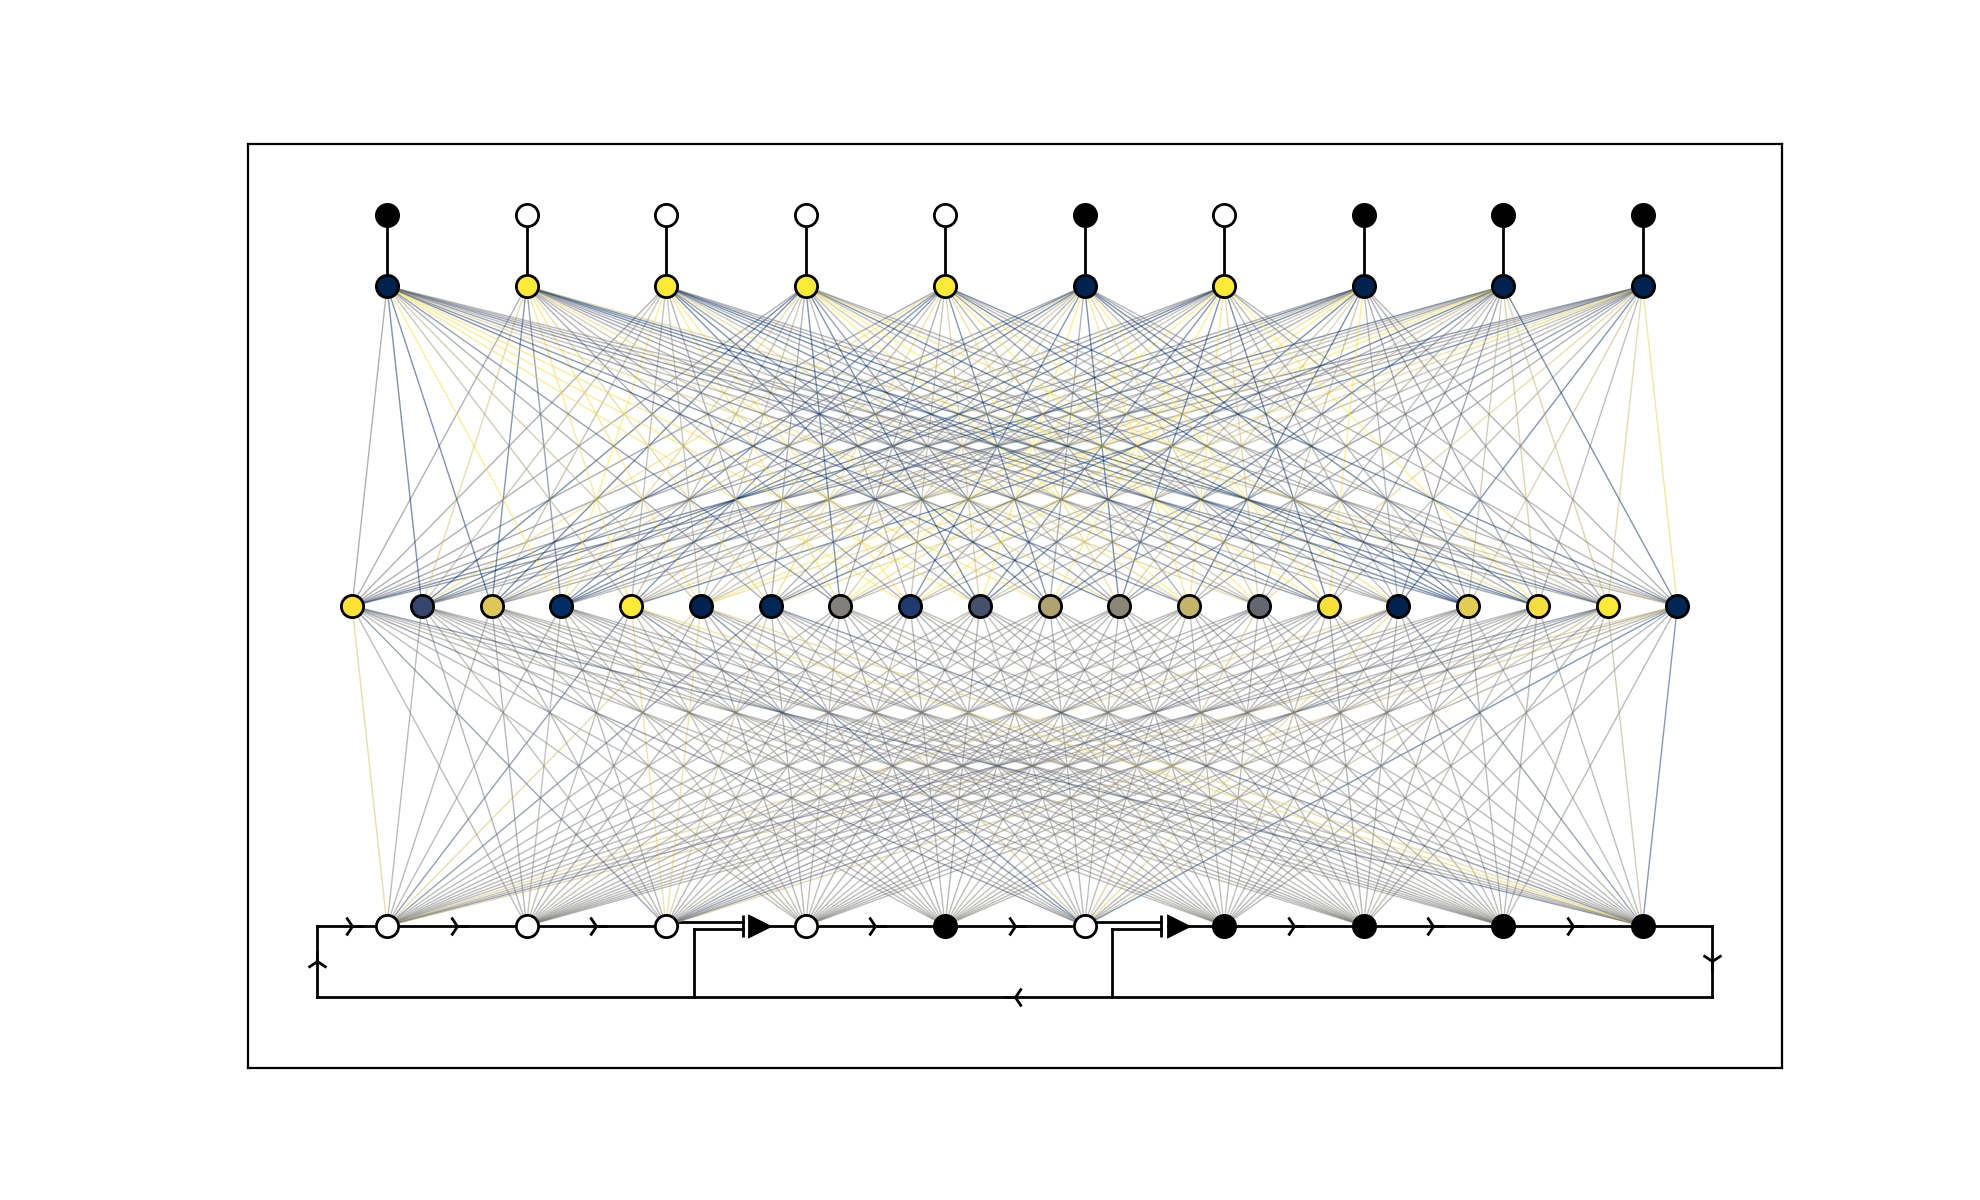

In [10]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 6),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'y_lim': [-0.2, 1.1],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 8,
    'link_width': 1,
    'net_link_alpha': 0.5,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

#############################
# Set up shop in new figure #
#############################

# New figure
plt.figure(figsize=config['figsize'])

# Draw LFSR corrsponding to tap polynomial
draw_lfsr(taps=str2vec(hex2bin(
    coeff_catalog[p], config['deg'])), 
    deg=config['deg'], 
    x_midpt=config['x_mid'],
    y_register=config['y_input'],
    y_feedback=config['y_LFSR_loop'],
    arrow_size=config['arrow_size'],
    lw=config['link_width'])

# Initialize neural net drawing
init_network_diagram(model=model,
    config=config, seed_bits=X[0,:],
    h_activations=h_activations[0,:],
    y_activations=Y_hat[0,:])

###############
# Format axes #
###############

# Vertical axis span
plt.ylim(config['y_lim']);

# Remove all axis ticks
plt.xticks([]);
plt.yticks([]);

In [11]:
type(model)

tensorflow.python.keras.engine.training.Model